# Credit Card Fraud Detection using Machine Learning

## Project Overview

This notebook develops a machine learning model to detect and prevent credit card fraud by identifying suspicious transactions. Machine learning provides an effective approach to automatically identify fraudulent transactions based on patterns in the data.

### What is Anomaly Detection?

**Anomaly detection** (also called outlier detection) is a technique used to identify rare items, events, or observations that deviate significantly from the majority of the data. In the context of credit card fraud:

- **Normal transactions** represent the majority of data (legitimate purchases)
- **Anomalies/Outliers** represent fraudulent transactions that exhibit unusual patterns

There are two main approaches to anomaly detection:
1. **Supervised Learning**: When we have labeled data (fraud/not fraud), we can train classifiers
2. **Unsupervised Learning**: When labels are unavailable, we identify anomalies based on statistical properties

Since our dataset is **labeled** (has a `Class` column), we'll use **supervised classification** while also exploring some unsupervised methods for comparison.

### Dataset Features

- `id`: Unique identifier for each transaction
- `V1-V28`: Anonymized features (result of PCA transformation for privacy)
- `Amount`: Transaction amount
- `Class`: Target variable (0 = legitimate, 1 = fraudulent)

## 1. Setup and Imports

We'll import all necessary libraries for data manipulation, visualization, and machine learning.

In [7]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Metrics and Evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading and Initial Exploration

Let's load the dataset and perform initial exploration to understand its structure.

In [8]:
# Load the dataset
# IMPORTANT: Update this path to your actual dataset location
df = pd.read_csv('creditcard_2023.csv')

# Display basic information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET OVERVIEW

Dataset Shape: 568,630 rows × 31 columns

Memory Usage: 134.49 MB


In [9]:
# Display first few rows
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [10]:
# Check data types and non-null counts
print("\nData Types and Non-Null Counts:")
print("-"*40)
df.info()


Data Types and Non-Null Counts:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     5686

In [11]:
# Statistical summary
print("\nStatistical Summary:")
df.describe()


Statistical Summary:


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,1.991314e-16,-1.183592e-16,-5.758017e-17,-5.698037e-18,-4.078595e-17,2.649087e-17,-1.719408e-17,-3.398829e-17,-5.837989e-17,2.479146e-17,-1.579456e-17,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,-3.163276e+00,-5.954723e+00,-2.020399e+00,-5.955227e+00,-2.107417e+00,-3.861813e+00,-2.214513e+00,-2.484938e+00,-2.421949e+00,-7.804988e+00,-7.814784e+01,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,-5.901008e-01,-7.014495e-01,-8.311331e-01,-6.966667e-01,-8.732057e-01,-6.212485e-01,-7.162655e-01,-6.194913e-01,-5.560458e-01,-5.653082e-01,-3.502399e-01,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,2.626145e-01,-4.104986e-02,1.620521e-01,1.760812e-02,2.305011e-01,-3.925566e-02,1.340262e-01,2.716407e-01,8.729382e-02,-2.597869e-02,-1.233776e-01,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,5.924603e-01,7.477730e-01,7.446723e-01,6.856048e-01,7.518216e-01,6.654065e-01,6.556061e-01,5.182242e-01,5.443887e-01,5.601164e-01,2.482164e-01,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,3.172271e+01,2.513573e+00,1.791356e+01,7.187486e+00,1.916954e+01,1.453220e+01,4.665291e+01,6.994124e+00,6.783716e+00,3.831672e+00,2.987281e+01,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


## 3. Data Quality Assessment

Before building our model, we need to check for:
- Missing values
- Duplicate records
- Data types consistency

In [12]:
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print("\n1. MISSING VALUES ANALYSIS")
print("-"*40)
if missing_values.sum() == 0:
    print(" No missing values found in the dataset!")
else:
    print("Missing values found:")
    missing_df = pd.DataFrame({
        'Missing Count': missing_values[missing_values > 0],
        'Percentage': missing_percentage[missing_values > 0]
    })
    print(missing_df)

# Check for duplicates
print("\n2. DUPLICATE RECORDS")
print("-"*40)
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates:,}")
print(f"Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")

# Check unique IDs
print("\n3. ID UNIQUENESS")
print("-"*40)
unique_ids = df['id'].nunique()
print(f"Total records: {len(df):,}")
print(f"Unique IDs: {unique_ids:,}")
print(f"IDs are unique: {unique_ids == len(df)}")

DATA QUALITY ASSESSMENT

1. MISSING VALUES ANALYSIS
----------------------------------------
 No missing values found in the dataset!

2. DUPLICATE RECORDS
----------------------------------------
Number of duplicate rows: 0
Percentage of duplicates: 0.00%

3. ID UNIQUENESS
----------------------------------------
Total records: 568,630
Unique IDs: 568,630
IDs are unique: True


## 4. Class Distribution Analysis (CRITICAL for Fraud Detection)

### Why Class Balance Matters

In fraud detection, class imbalance is a critical concern:

- **Imbalanced datasets** (typical in real-world fraud): ~99% legitimate, ~1% fraudulent
- **Balanced datasets**: Roughly equal distribution between classes

**Impact of Imbalance:**
- Models may become biased toward the majority class
- High accuracy can be misleading (predicting all as legitimate gives 99% accuracy but catches 0 frauds)
- Special techniques needed: oversampling, undersampling, cost-sensitive learning

Let's analyze our dataset's class distribution:

In [13]:
print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

# Calculate class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print("-"*40)
print(f"Legitimate Transactions (Class 0): {class_counts[0]:,} ({class_percentages[0]:.2f}%)")
print(f"Fraudulent Transactions (Class 1): {class_counts[1]:,} ({class_percentages[1]:.2f}%)")
print(f"\nClass Ratio (Legitimate:Fraudulent): {class_counts[0]/class_counts[1]:.2f}:1")

# Determine if balanced
imbalance_ratio = class_counts[0] / class_counts[1]
if 0.8 <= class_percentages[1]/class_percentages[0] <= 1.2:
    balance_status = "BALANCED"
    balance_note = """The dataset is balanced, meaning both classes have similar representation.
This simplifies our modeling approach as we don't need to apply special techniques
like SMOTE (Synthetic Minority Over-sampling Technique) or class weights."""
else:
    balance_status = "IMBALANCED"
    balance_note = "The dataset is imbalanced. Consider using techniques like SMOTE or class weights."

print(f"\nDataset Status: {balance_status}")
print(f"\nNote: {balance_note}")

CLASS DISTRIBUTION ANALYSIS

Class Distribution:
----------------------------------------
Legitimate Transactions (Class 0): 284,315 (50.00%)
Fraudulent Transactions (Class 1): 284,315 (50.00%)

Class Ratio (Legitimate:Fraudulent): 1.00:1

Dataset Status: BALANCED

Note: The dataset is balanced, meaning both classes have similar representation.
This simplifies our modeling approach as we don't need to apply special techniques
like SMOTE (Synthetic Minority Over-sampling Technique) or class weights.


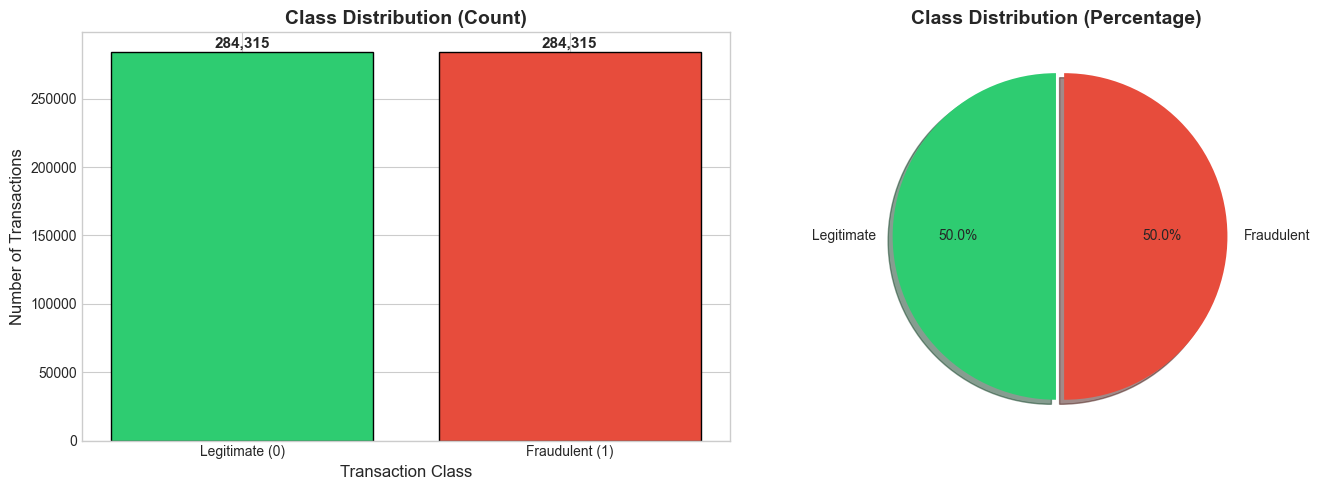

In [14]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Legitimate (0)', 'Fraudulent (1)'], class_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Transactions', fontsize=12)
axes[0].set_xlabel('Transaction Class', fontsize=12)

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=['Legitimate', 'Fraudulent'], 
            autopct='%1.1f%%', colors=colors, explode=(0, 0.05),
            shadow=True, startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Analysis

### Understanding the Features

The features V1-V28 are the result of **Principal Component Analysis (PCA)** transformation. This was done to:
1. **Protect sensitive information** (anonymization)
2. **Reduce dimensionality** while preserving variance
3. **Remove multicollinearity** between original features

The `Amount` feature was NOT transformed and represents the actual transaction amount.

In [15]:
# Analyze the Amount feature
print("="*60)
print("AMOUNT FEATURE ANALYSIS")
print("="*60)

print("\nAmount Statistics by Class:")
print("-"*40)
amount_stats = df.groupby('Class')['Amount'].describe()
print(amount_stats)

# Compare mean and median
print("\n\nKey Observations:")
print("-"*40)
legit_mean = df[df['Class']==0]['Amount'].mean()
fraud_mean = df[df['Class']==1]['Amount'].mean()
legit_median = df[df['Class']==0]['Amount'].median()
fraud_median = df[df['Class']==1]['Amount'].median()

print(f"Legitimate - Mean: ${legit_mean:.2f}, Median: ${legit_median:.2f}")
print(f"Fraudulent - Mean: ${fraud_mean:.2f}, Median: ${fraud_median:.2f}")

AMOUNT FEATURE ANALYSIS

Amount Statistics by Class:
----------------------------------------
          count          mean          std    min      25%       50%  \
Class                                                                  
0      284315.0  12026.313506  6929.500715  50.12  6034.54  11996.90   
1      284315.0  12057.601763  6909.750891  50.01  6074.64  12062.45   

             75%       max  
Class                       
0      18040.265  24039.93  
1      18033.780  24039.93  


Key Observations:
----------------------------------------
Legitimate - Mean: $12026.31, Median: $11996.90
Fraudulent - Mean: $12057.60, Median: $12062.45


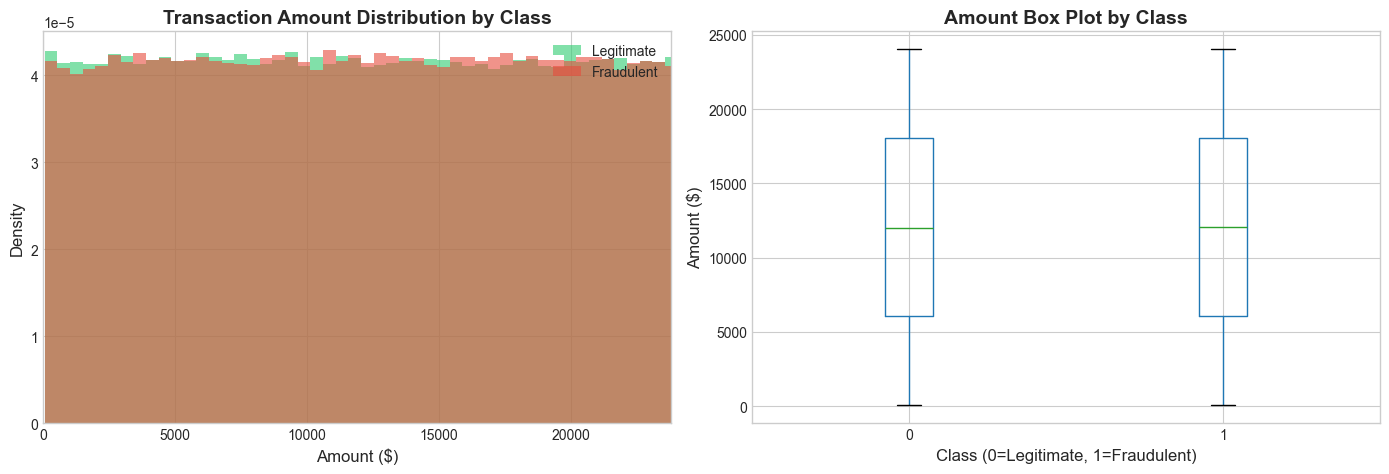

In [16]:
# Visualize Amount distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution by class
for cls, color, label in [(0, '#2ecc71', 'Legitimate'), (1, '#e74c3c', 'Fraudulent')]:
    subset = df[df['Class'] == cls]['Amount']
    axes[0].hist(subset, bins=50, alpha=0.6, color=color, label=label, density=True)

axes[0].set_title('Transaction Amount Distribution by Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Amount ($)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend()
axes[0].set_xlim(0, df['Amount'].quantile(0.99))  # Limit to 99th percentile for better visualization

# Box plot
df.boxplot(column='Amount', by='Class', ax=axes[1])
axes[1].set_title('Amount Box Plot by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class (0=Legitimate, 1=Fraudulent)', fontsize=12)
axes[1].set_ylabel('Amount ($)', fontsize=12)
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig('amount_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Analyze V features - Distribution comparison
v_features = [f'V{i}' for i in range(1, 29)]

# Calculate mean differences between classes
mean_diff = []
for feature in v_features:
    fraud_mean = df[df['Class']==1][feature].mean()
    legit_mean = df[df['Class']==0][feature].mean()
    mean_diff.append(abs(fraud_mean - legit_mean))

# Sort features by discriminative power
feature_importance_df = pd.DataFrame({
    'Feature': v_features,
    'Mean_Difference': mean_diff
}).sort_values('Mean_Difference', ascending=False)

print("="*60)
print("TOP DISCRIMINATIVE FEATURES (by mean difference)")
print("="*60)
print("\nFeatures with largest mean difference between classes:")
print("(These features may be most useful for distinguishing fraud)")
print("-"*40)
print(feature_importance_df.head(10).to_string(index=False))

TOP DISCRIMINATIVE FEATURES (by mean difference)

Features with largest mean difference between classes:
(These features may be most useful for distinguishing fraud)
----------------------------------------
Feature  Mean_Difference
    V14         1.611338
    V12         1.537159
     V4         1.471962
    V11         1.448556
     V3         1.364191
    V10         1.347330
     V9         1.171043
    V16         1.147023
     V1         1.011522
     V2         0.983756


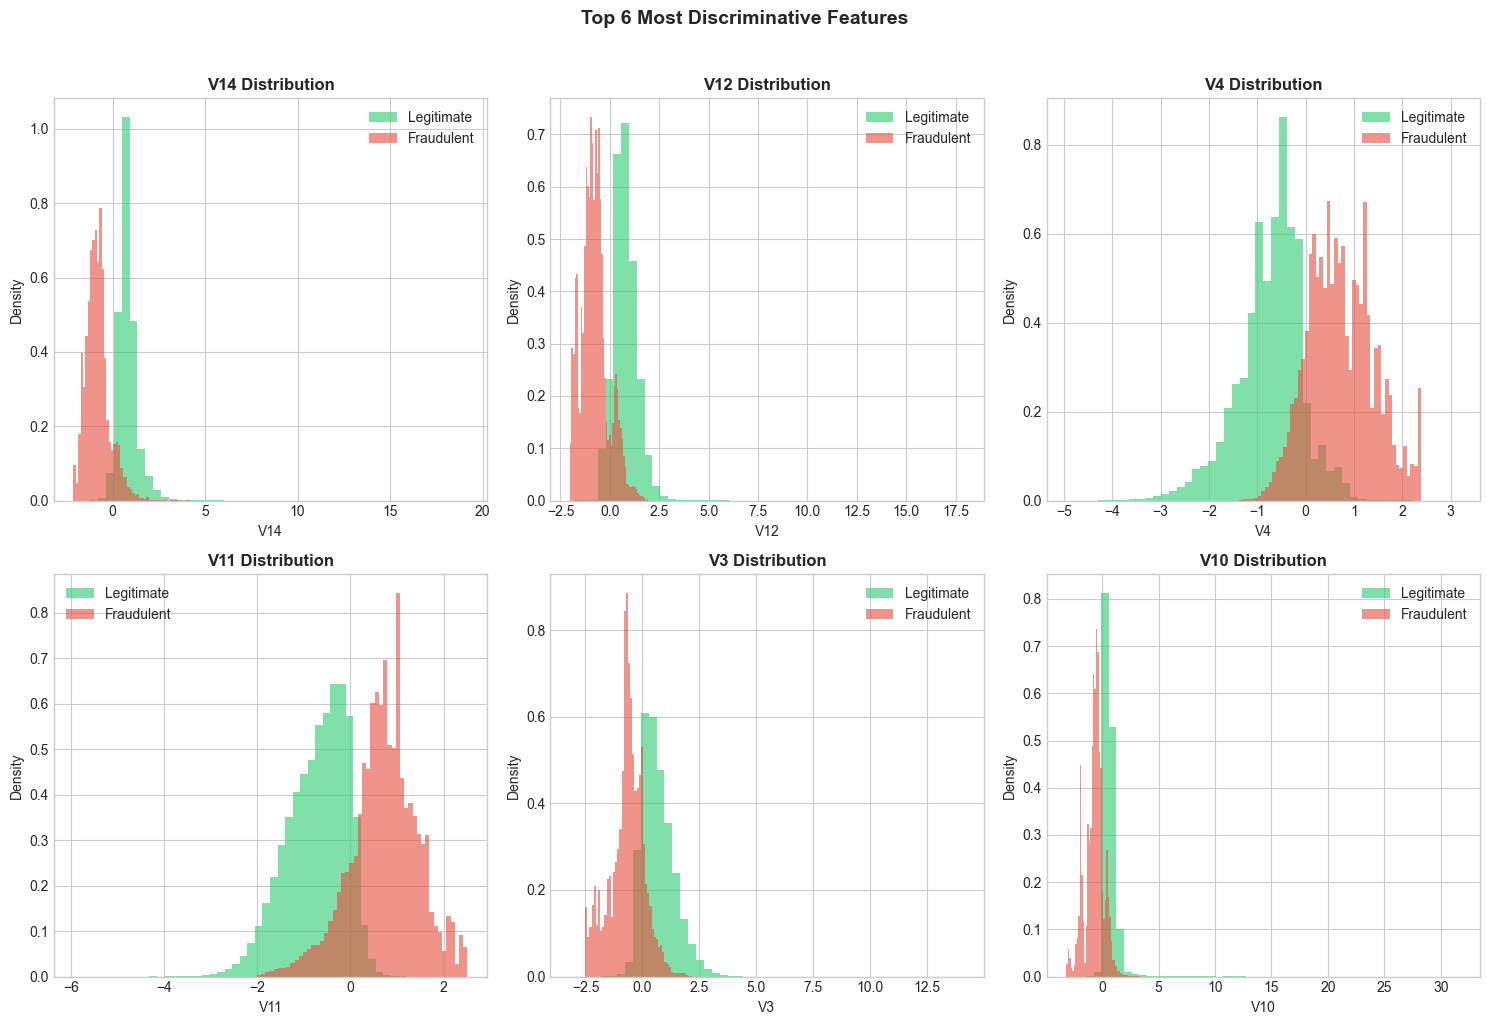

In [18]:
# Visualize top discriminative features
top_features = feature_importance_df['Feature'].head(6).tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    for cls, color, label in [(0, '#2ecc71', 'Legitimate'), (1, '#e74c3c', 'Fraudulent')]:
        subset = df[df['Class'] == cls][feature]
        axes[idx].hist(subset, bins=50, alpha=0.6, color=color, label=label, density=True)
    
    axes[idx].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

plt.suptitle('Top 6 Most Discriminative Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('top_features_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Correlation Analysis

In [19]:
# Calculate correlations with target
correlations = df.drop('id', axis=1).corr()['Class'].drop('Class').sort_values(key=abs, ascending=False)

print("="*60)
print("CORRELATION WITH TARGET (Class)")
print("="*60)
print("\nTop 10 features most correlated with fraud:")
print("-"*40)
print(correlations.head(10))

print("\n\nBottom 10 features least correlated with fraud:")
print("-"*40)
print(correlations.tail(10))

CORRELATION WITH TARGET (Class)

Top 10 features most correlated with fraud:
----------------------------------------
V14   -0.805669
V12   -0.768579
V4     0.735981
V11    0.724278
V3    -0.682095
V10   -0.673665
V9    -0.585522
V16   -0.573511
V1    -0.505761
V2     0.491878
Name: Class, dtype: float64


Bottom 10 features least correlated with fraud:
----------------------------------------
V24      -0.130107
V21       0.109640
V28       0.102024
V13      -0.071105
V26       0.071052
V25       0.061847
V15      -0.037948
V22       0.014098
V23       0.010255
Amount    0.002261
Name: Class, dtype: float64


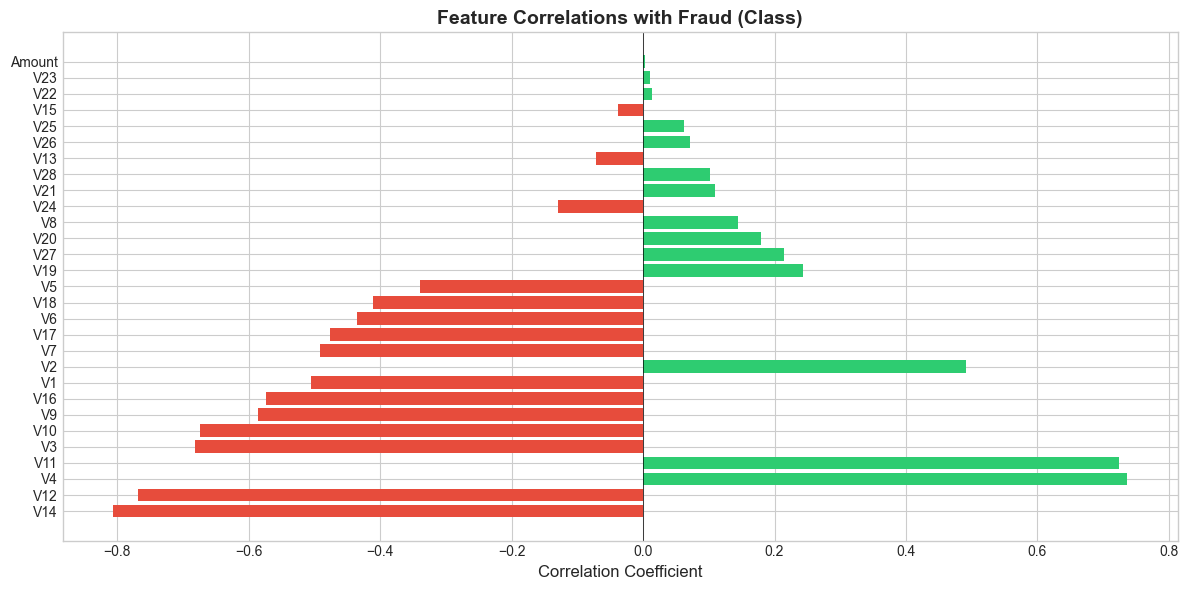

In [20]:
# Visualize correlations with target
plt.figure(figsize=(12, 6))

colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in correlations.values]
plt.barh(range(len(correlations)), correlations.values, color=colors)
plt.yticks(range(len(correlations)), correlations.index)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.title('Feature Correlations with Fraud (Class)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('correlation_with_target.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Data Preprocessing

### Preprocessing Steps:

1. **Remove non-predictive features**: The `id` column is just an identifier
2. **Feature Scaling**: Important for algorithms like Logistic Regression
   - V1-V28 are already scaled (from PCA)
   - `Amount` needs scaling

### Why Scale Features?

- **Gradient-based algorithms** (Logistic Regression, Neural Networks) converge faster
- **Distance-based algorithms** (KNN, SVM) are sensitive to feature magnitudes
- **Tree-based algorithms** (Random Forest, XGBoost) are scale-invariant but scaling doesn't hurt

In [21]:
print("="*60)
print("DATA PREPROCESSING")
print("="*60)

# Create a copy for preprocessing
df_processed = df.copy()

# Remove the id column
print("\n1. Removing non-predictive features...")
print("    Dropping 'id' column")
df_processed = df_processed.drop('id', axis=1)

# Separate features and target
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

print(f"\n2. Feature matrix shape: {X.shape}")
print(f"   Target vector shape: {y.shape}")

# Scale the Amount feature using RobustScaler
# RobustScaler is better for data with outliers as it uses median and IQR
print("\n3. Scaling 'Amount' feature using RobustScaler...")
print("    RobustScaler chosen because Amount has outliers")
print("    Uses median and IQR instead of mean and std")

scaler = RobustScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

print("\n Preprocessing complete!")
print(f"\nFinal feature statistics:")
print(X.describe().T[['mean', 'std', 'min', 'max']].head(10))

DATA PREPROCESSING

1. Removing non-predictive features...
    Dropping 'id' column

2. Feature matrix shape: (568630, 29)
   Target vector shape: (568630,)

3. Scaling 'Amount' feature using RobustScaler...
    RobustScaler chosen because Amount has outliers
    Uses median and IQR instead of mean and std

 Preprocessing complete!

Final feature statistics:
             mean       std        min         max
V1  -5.638058e-17  1.000001  -3.495584    2.229046
V2  -1.319545e-16  1.000001 -49.966572    4.361865
V3  -3.518788e-17  1.000001  -3.183760   14.125834
V4  -2.879008e-17  1.000001  -4.951222    3.201536
V5   7.997245e-18  1.000001  -9.952786   42.716891
V6  -3.958636e-17  1.000001 -21.111108   26.168402
V7  -3.198898e-17  1.000001  -4.351839  217.873038
V8   2.109273e-17  1.000001 -10.756342    5.958040
V9   3.998623e-17  1.000001  -3.751919   20.270062
V10  1.991314e-16  1.000001  -3.163276   31.722709


## 8. Train-Test Split

### Why Split the Data?

We need to evaluate our model on data it has never seen during training. This gives us an unbiased estimate of real-world performance.

### Split Strategy:

- **Training Set (80%)**: Used to train the model
- **Test Set (20%)**: Used for final evaluation (held out, never used during training)

### Important: Stratified Splitting

We use **stratified splitting** to ensure both training and test sets have the same class distribution as the original dataset. This is crucial for classification problems to ensure representative evaluation.

In [22]:
print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,           # 20% for testing
    random_state=RANDOM_STATE, # For reproducibility
    stratify=y                 # Maintain class distribution
)

print("\nSplit Configuration:")
print("-"*40)
print(f" Test size: 20%")
print(f" Stratified: Yes (maintains class proportions)")
print(f" Random state: {RANDOM_STATE} (for reproducibility)")

print("\n\nDataset Sizes:")
print("-"*40)
print(f" Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print("\n\nClass Distribution Verification:")
print("-"*40)
print(f"Original - Class 0: {(y==0).sum()/len(y)*100:.2f}%, Class 1: {(y==1).sum()/len(y)*100:.2f}%")
print(f"Training - Class 0: {(y_train==0).sum()/len(y_train)*100:.2f}%, Class 1: {(y_train==1).sum()/len(y_train)*100:.2f}%")
print(f"Test     - Class 0: {(y_test==0).sum()/len(y_test)*100:.2f}%, Class 1: {(y_test==1).sum()/len(y_test)*100:.2f}%")

print("\n Stratification maintained class proportions in both sets!")

TRAIN-TEST SPLIT

Split Configuration:
----------------------------------------
 Test size: 20%
 Stratified: Yes (maintains class proportions)
 Random state: 42 (for reproducibility)


Dataset Sizes:
----------------------------------------
 Training set: 454,904 samples (80.0%)
 Test set: 113,726 samples (20.0%)


Class Distribution Verification:
----------------------------------------
Original - Class 0: 50.00%, Class 1: 50.00%
Training - Class 0: 50.00%, Class 1: 50.00%
Test     - Class 0: 50.00%, Class 1: 50.00%

 Stratification maintained class proportions in both sets!


## 9. Model Selection and Training

### Models to Evaluate:

1. **Logistic Regression**: Simple, interpretable baseline
2. **Decision Tree**: Non-linear, easy to interpret
3. **Random Forest**: Ensemble of trees, robust to overfitting
4. **XGBoost**: Gradient boosting, often best performance

### Why These Models?

| Model | Pros | Cons |
|-------|------|------|
| Logistic Regression | Fast, interpretable, good baseline | Limited to linear relationships |
| Decision Tree | Handles non-linearity, interpretable | Prone to overfitting |
| Random Forest | Reduces overfitting, handles complex patterns | Less interpretable, slower |
| XGBoost | State-of-the-art performance, handles imbalance | Complex to tune, less interpretable |

In [23]:
print("="*60)
print("MODEL TRAINING")
print("="*60)

# Define models
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        solver='lbfgs'
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=10,  # Limit depth to prevent overfitting
        min_samples_split=10
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=15,
        min_samples_split=10,
        n_jobs=-1  # Use all CPU cores
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

# Train all models and store results
trained_models = {}
training_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Store results
    training_results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print(f"    {name} trained successfully!")

print("\n" + "="*60)
print("All models trained successfully!")
print("="*60)

MODEL TRAINING

Training Logistic Regression...
    Logistic Regression trained successfully!

Training Decision Tree...
    Decision Tree trained successfully!

Training Random Forest...
    Random Forest trained successfully!

Training XGBoost...
    XGBoost trained successfully!

All models trained successfully!


## 10. Model Evaluation Metrics

### Understanding the Metrics

For fraud detection, **accuracy alone is NOT sufficient**. Here's why each metric matters:

| Metric | Formula | What it Measures | Why it Matters for Fraud |
|--------|---------|------------------|-------------------------|
| **Accuracy** | (TP+TN)/(Total) | Overall correctness | Can be misleading with imbalanced data |
| **Precision** | TP/(TP+FP) | Of predicted frauds, how many are real? | High FP = legitimate transactions blocked |
| **Recall** | TP/(TP+FN) | Of actual frauds, how many caught? | High FN = frauds go undetected (costly!) |
| **F1 Score** | 2×(P×R)/(P+R) | Balance of Precision & Recall | Overall fraud detection effectiveness |
| **ROC-AUC** | Area under ROC curve | Ability to distinguish classes | Performance across all thresholds |

### Key Concepts:

- **True Positive (TP)**: Correctly identified fraud
- **True Negative (TN)**: Correctly identified legitimate transaction
- **False Positive (FP)**: Legitimate transaction flagged as fraud (customer inconvenience)
- **False Negative (FN)**: Fraud not detected (financial loss!)

### For Fraud Detection:
- **Recall is often most important** because missing a fraud (FN) is typically more costly than a false alarm (FP)
- However, very low precision creates too many false alarms, frustrating legitimate customers

In [24]:
print("="*60)
print("MODEL COMPARISON - EVALUATION METRICS")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(training_results.keys()),
    'Accuracy': [training_results[m]['accuracy'] for m in training_results],
    'Precision': [training_results[m]['precision'] for m in training_results],
    'Recall': [training_results[m]['recall'] for m in training_results],
    'F1 Score': [training_results[m]['f1'] for m in training_results],
    'ROC-AUC': [training_results[m]['roc_auc'] for m in training_results]
})

# Format as percentages
comparison_display = comparison_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
    comparison_display[col] = comparison_display[col].apply(lambda x: f"{x*100:.2f}%")

print("\n")
print(comparison_display.to_string(index=False))

# Find best model for each metric
print("\n\nBest Model by Metric:")
print("-"*40)
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
    best_idx = comparison_df[col].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, col]
    print(f"{col}: {best_model} ({best_value*100:.2f}%)")

MODEL COMPARISON - EVALUATION METRICS


              Model Accuracy Precision Recall F1 Score ROC-AUC
Logistic Regression   96.50%    97.70% 95.23%   96.45%  99.35%
      Decision Tree   98.62%    98.58% 98.67%   98.62%  99.66%
      Random Forest   99.89%    99.94% 99.84%   99.89% 100.00%
            XGBoost   99.77%    99.71% 99.84%   99.77%  99.99%


Best Model by Metric:
----------------------------------------
Accuracy: Random Forest (99.89%)
Precision: Random Forest (99.94%)
Recall: XGBoost (99.84%)
F1 Score: Random Forest (99.89%)
ROC-AUC: Random Forest (100.00%)


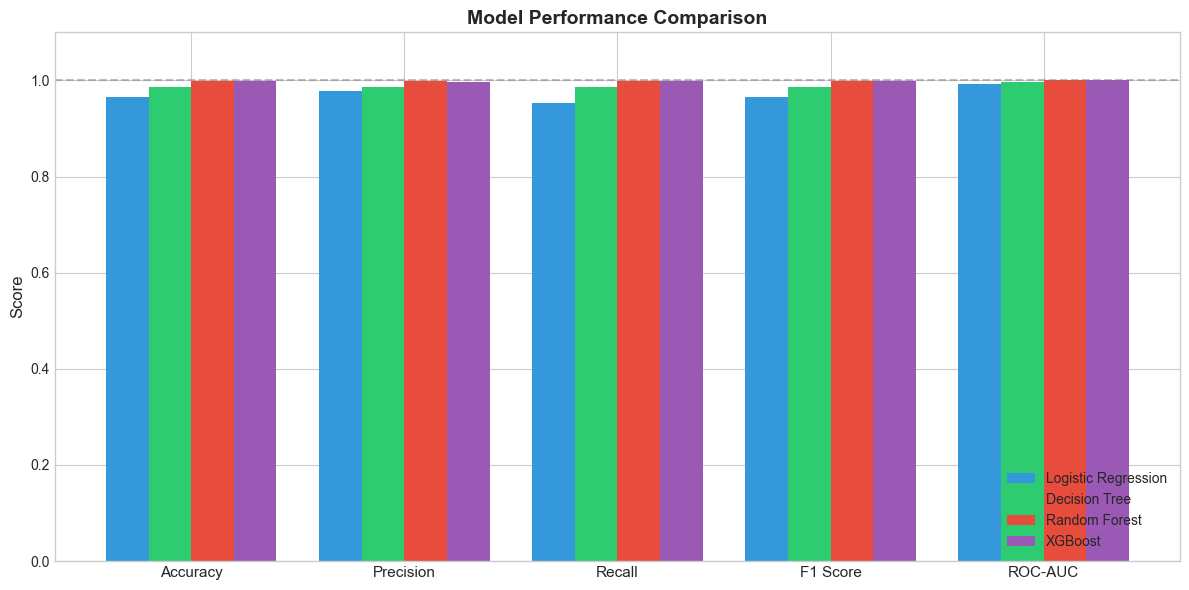

In [25]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2
multiplier = 0

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for idx, (model_name, results) in enumerate(training_results.items()):
    values = [results['accuracy'], results['precision'], results['recall'], 
              results['f1'], results['roc_auc']]
    offset = width * multiplier
    bars = ax.bar(x + offset, values, width, label=model_name, color=colors[idx])
    multiplier += 1

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim(0, 1.1)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Confusion Matrix Analysis

### What is a Confusion Matrix?

A confusion matrix is a table that visualizes the performance of a classification model by showing the counts of:
- **True Positives (TP)**: Correctly predicted frauds
- **True Negatives (TN)**: Correctly predicted legitimate transactions
- **False Positives (FP)**: Legitimate transactions incorrectly flagged as fraud
- **False Negatives (FN)**: Frauds that were not detected

```
                    Predicted
                 Negative  Positive
Actual Negative    TN        FP
Actual Positive    FN        TP
```

### Business Impact:
- **FP (False Alarms)**: Customer inconvenience, declined legitimate purchases
- **FN (Missed Frauds)**: Financial losses, customer trust damage

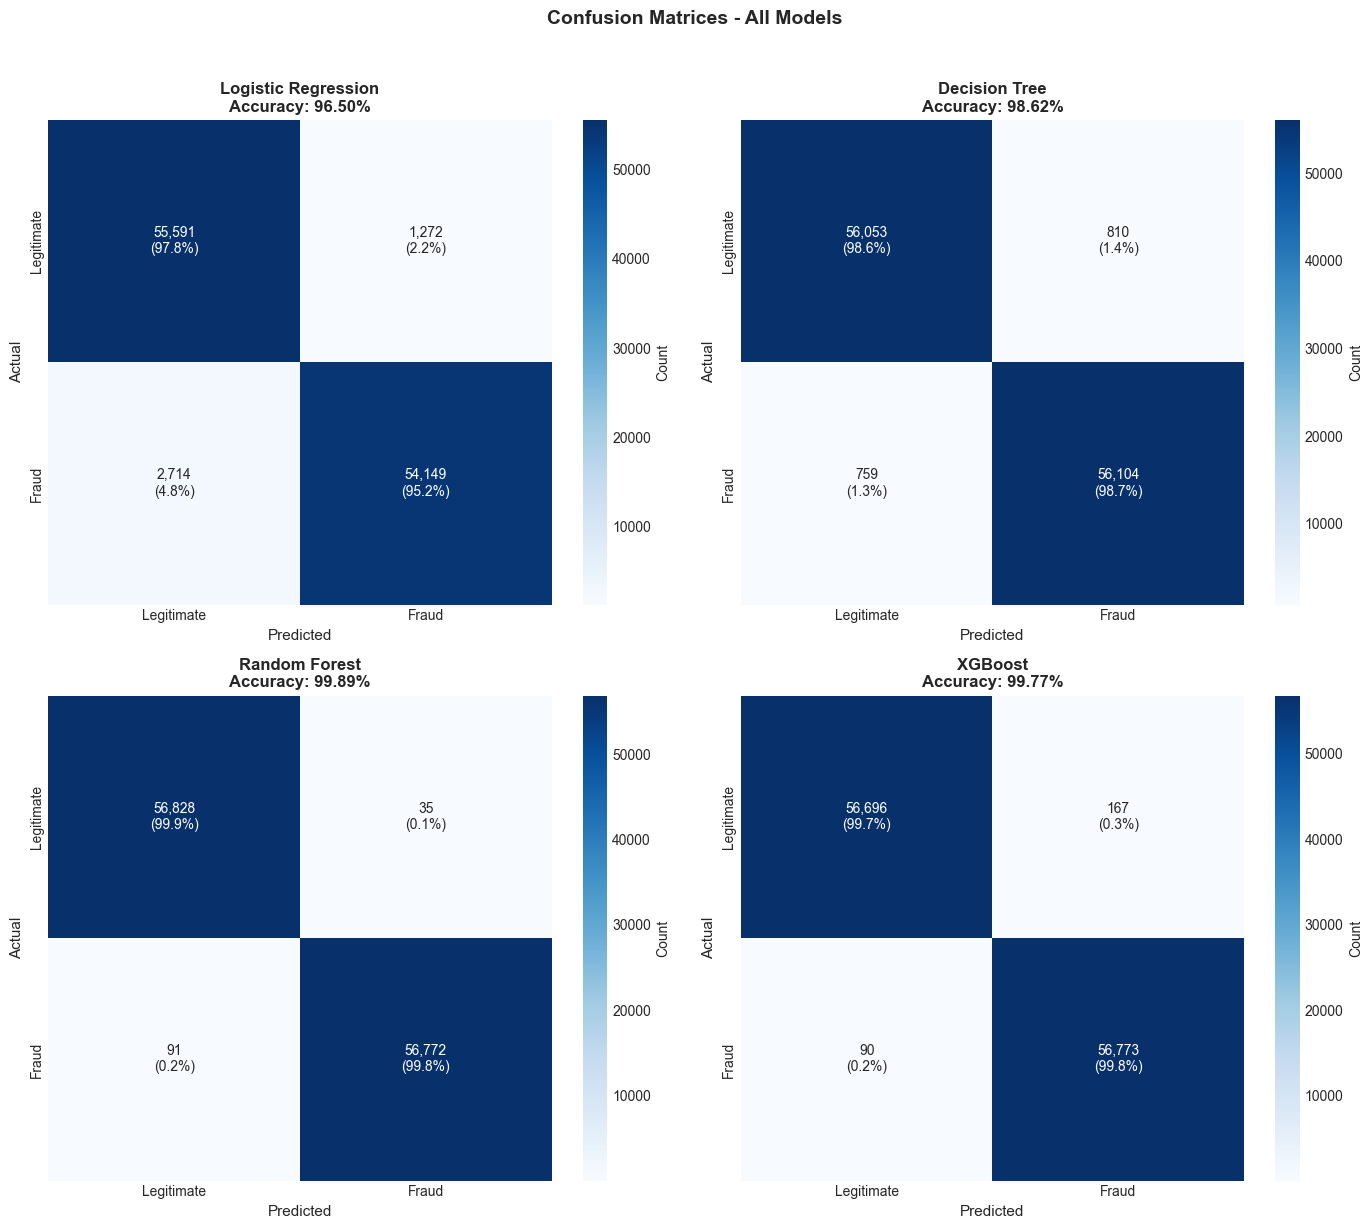

In [26]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(training_results.items()):
    cm = confusion_matrix(y_test, results['y_pred'])
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both count and percentage
    annotations = np.array([[f'{cm[i,j]:,}\n({cm_percent[i,j]:.1f}%)' 
                            for j in range(2)] for i in range(2)])
    
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', ax=axes[idx],
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'],
                cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(f'{model_name}\nAccuracy: {results["accuracy"]*100:.2f}%', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=11)

plt.suptitle('Confusion Matrices - All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [27]:
# Detailed confusion matrix analysis
print("="*60)
print("DETAILED CONFUSION MATRIX ANALYSIS")
print("="*60)

for model_name, results in training_results.items():
    cm = confusion_matrix(y_test, results['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{model_name}:")
    print("-"*40)
    print(f"  True Negatives (TN):  {tn:,} - Correctly identified legitimate")
    print(f"  False Positives (FP): {fp:,} - Legitimate flagged as fraud (false alarm)")
    print(f"  False Negatives (FN): {fn:,} - Fraud not detected (MISSED!)")
    print(f"  True Positives (TP):  {tp:,} - Correctly identified fraud")
    print(f"\n  Detection Rate: {tp/(tp+fn)*100:.2f}% of frauds caught")
    print(f"  False Alarm Rate: {fp/(fp+tn)*100:.2f}% of legitimate flagged")

DETAILED CONFUSION MATRIX ANALYSIS

Logistic Regression:
----------------------------------------
  True Negatives (TN):  55,591 - Correctly identified legitimate
  False Positives (FP): 1,272 - Legitimate flagged as fraud (false alarm)
  False Negatives (FN): 2,714 - Fraud not detected (MISSED!)
  True Positives (TP):  54,149 - Correctly identified fraud

  Detection Rate: 95.23% of frauds caught
  False Alarm Rate: 2.24% of legitimate flagged

Decision Tree:
----------------------------------------
  True Negatives (TN):  56,053 - Correctly identified legitimate
  False Positives (FP): 810 - Legitimate flagged as fraud (false alarm)
  False Negatives (FN): 759 - Fraud not detected (MISSED!)
  True Positives (TP):  56,104 - Correctly identified fraud

  Detection Rate: 98.67% of frauds caught
  False Alarm Rate: 1.42% of legitimate flagged

Random Forest:
----------------------------------------
  True Negatives (TN):  56,828 - Correctly identified legitimate
  False Positives (FP): 3

## 12. ROC Curve and AUC Analysis

### What is ROC-AUC?

**ROC (Receiver Operating Characteristic)** curve plots:
- **True Positive Rate (Sensitivity/Recall)** vs **False Positive Rate (1 - Specificity)**
- At various classification thresholds

**AUC (Area Under Curve)**:
- Ranges from 0 to 1
- 0.5 = Random guessing (diagonal line)
- 1.0 = Perfect classifier
- Higher is better

### Interpretation:
- **AUC > 0.9**: Excellent
- **AUC 0.8-0.9**: Good
- **AUC 0.7-0.8**: Fair
- **AUC < 0.7**: Poor

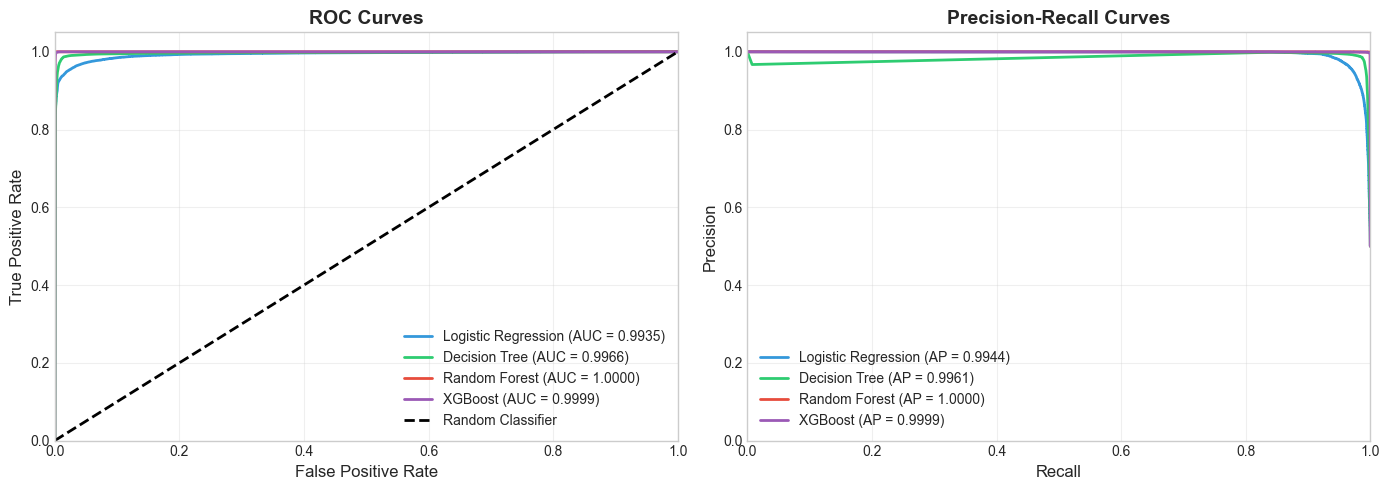

In [28]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# ROC Curve
for idx, (model_name, results) in enumerate(training_results.items()):
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    auc = roc_auc_score(y_test, results['y_pred_proba'])
    axes[0].plot(fpr, tpr, color=colors[idx], lw=2, 
                 label=f'{model_name} (AUC = {auc:.4f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
for idx, (model_name, results) in enumerate(training_results.items()):
    precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
    ap = average_precision_score(y_test, results['y_pred_proba'])
    axes[1].plot(recall, precision, color=colors[idx], lw=2, 
                 label=f'{model_name} (AP = {ap:.4f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Cross-Validation

### Why Cross-Validation?

A single train-test split might give results that depend on how the data was split. **Cross-validation** provides a more robust estimate by:

1. Splitting data into K folds
2. Training K times, each time using a different fold as validation
3. Averaging results across all folds

### Stratified K-Fold:
We use **Stratified** K-Fold to maintain class proportions in each fold, which is especially important for classification problems.

In [30]:
print("="*60)
print("CROSS-VALIDATION (5-Fold Stratified)")
print("="*60)

# Perform 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}

print("\nPerforming cross-validation for each model...")
print("(This may take a moment)\n")

for name, model in models.items():
    print(f"Cross-validating {name}...")
    
    # Calculate CV scores for multiple metrics
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    precision_scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
    recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    
    cv_results[name] = {
        'Accuracy': (accuracy_scores.mean(), accuracy_scores.std()),
        'Precision': (precision_scores.mean(), precision_scores.std()),
        'Recall': (recall_scores.mean(), recall_scores.std()),
        'F1 Score': (f1_scores.mean(), f1_scores.std()),
        'ROC-AUC': (roc_auc_scores.mean(), roc_auc_scores.std())
    }

print("\n Cross-validation complete!")

CROSS-VALIDATION (5-Fold Stratified)

Performing cross-validation for each model...
(This may take a moment)

Cross-validating Logistic Regression...
Cross-validating Decision Tree...
Cross-validating Random Forest...
Cross-validating XGBoost...

 Cross-validation complete!


In [31]:
# Display CV results
print("\nCross-Validation Results (Mean ± Std):")
print("="*80)

for name, results in cv_results.items():
    print(f"\n{name}:")
    print("-"*50)
    for metric, (mean, std) in results.items():
        print(f"  {metric:12s}: {mean*100:.2f}% (± {std*100:.2f}%)")

print("\n" + "="*80)
print("\nInterpretation:")
print("-"*50)
print(" Low standard deviation indicates consistent performance across folds")
print(" High standard deviation suggests the model is sensitive to data splits")


Cross-Validation Results (Mean ± Std):

Logistic Regression:
--------------------------------------------------
  Accuracy    : 96.49% (± 0.03%)
  Precision   : 97.78% (± 0.06%)
  Recall      : 95.14% (± 0.03%)
  F1 Score    : 96.44% (± 0.03%)
  ROC-AUC     : 99.35% (± 0.01%)

Decision Tree:
--------------------------------------------------
  Accuracy    : 98.57% (± 0.08%)
  Precision   : 98.55% (± 0.14%)
  Recall      : 98.58% (± 0.08%)
  F1 Score    : 98.57% (± 0.08%)
  ROC-AUC     : 99.68% (± 0.01%)

Random Forest:
--------------------------------------------------
  Accuracy    : 99.91% (± 0.02%)
  Precision   : 99.94% (± 0.01%)
  Recall      : 99.87% (± 0.04%)
  F1 Score    : 99.91% (± 0.02%)
  ROC-AUC     : 100.00% (± 0.00%)

XGBoost:
--------------------------------------------------
  Accuracy    : 99.78% (± 0.02%)
  Precision   : 99.72% (± 0.03%)
  Recall      : 99.84% (± 0.01%)
  F1 Score    : 99.78% (± 0.02%)
  ROC-AUC     : 99.99% (± 0.00%)


Interpretation:
-------------

## 14. Feature Importance Analysis

Understanding which features are most important helps us:
1. Interpret the model's decisions
2. Potentially reduce features for simpler models
3. Gain business insights about fraud patterns

In [32]:
# Get feature importances from tree-based models
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': trained_models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': trained_models['XGBoost'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features - Random Forest:")
print("-"*40)
print(rf_importance.head(10).to_string(index=False))

print("\n\nTop 10 Features - XGBoost:")
print("-"*40)
print(xgb_importance.head(10).to_string(index=False))

FEATURE IMPORTANCE ANALYSIS

Top 10 Features - Random Forest:
----------------------------------------
Feature  Importance
    V10    0.159101
    V14    0.149657
     V4    0.144768
    V12    0.110681
    V11    0.089349
    V17    0.061516
    V16    0.053662
     V7    0.043708
     V3    0.034484
     V2    0.022117


Top 10 Features - XGBoost:
----------------------------------------
Feature  Importance
    V14    0.648337
     V4    0.053707
    V12    0.023313
     V1    0.019930
     V8    0.019739
     V3    0.018459
     V2    0.015881
    V17    0.013984
    V28    0.013442
    V10    0.013107


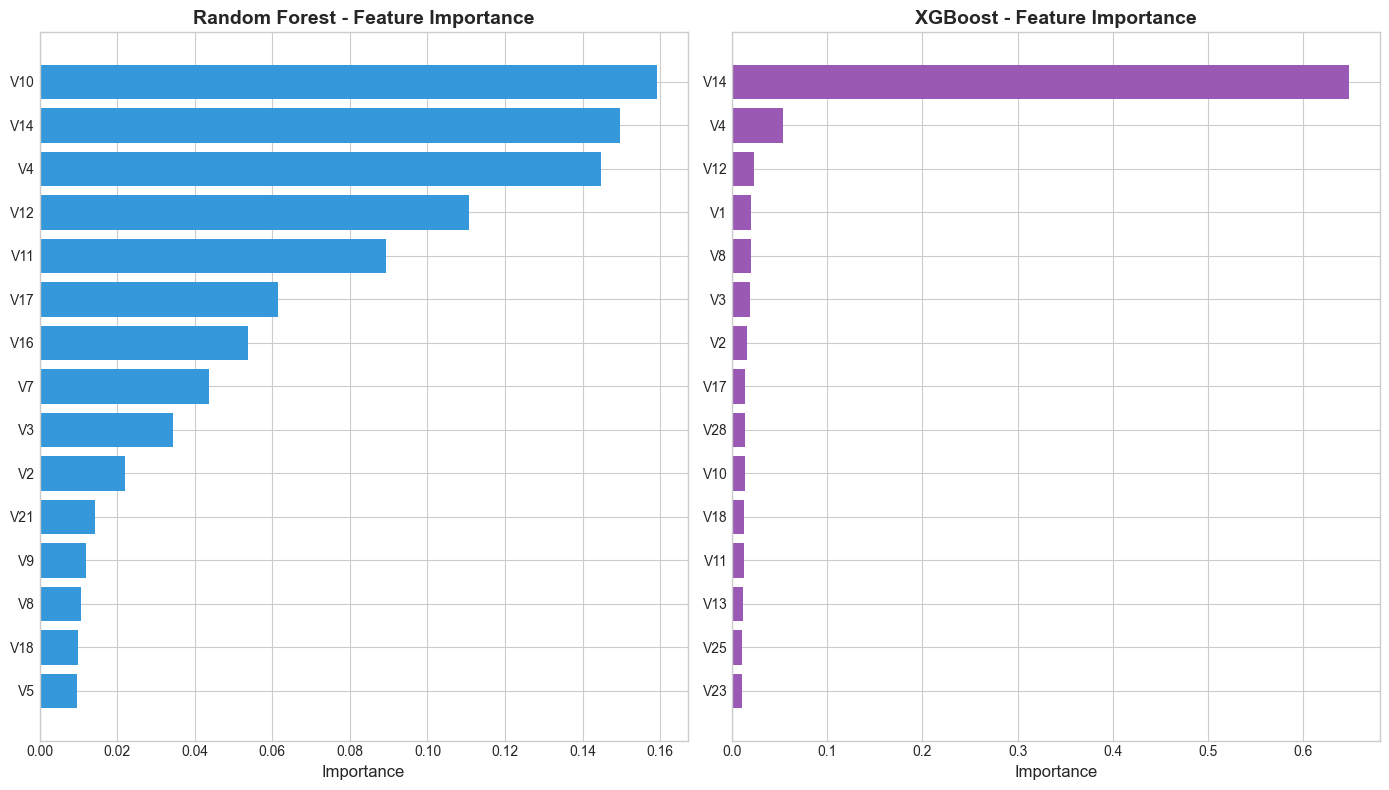

In [33]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Random Forest
top_rf = rf_importance.head(15)
axes[0].barh(range(len(top_rf)), top_rf['Importance'].values, color='#3498db')
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['Feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')

# XGBoost
top_xgb = xgb_importance.head(15)
axes[1].barh(range(len(top_xgb)), top_xgb['Importance'].values, color='#9b59b6')
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['Feature'].values)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('XGBoost - Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. Unsupervised Anomaly Detection

For comparison, let's also try **Isolation Forest**, an unsupervised anomaly detection algorithm.

### How Isolation Forest Works:

1. Builds random trees by randomly selecting features and split values
2. Anomalies are isolated earlier (fewer splits needed) because they are different from normal points
3. Normal points require more splits to isolate

This approach is useful when labeled data is scarce or unavailable.

In [34]:
print("="*60)
print("UNSUPERVISED ANOMALY DETECTION - Isolation Forest")
print("="*60)

# Train Isolation Forest
# contamination is set based on our knowledge of fraud ratio
fraud_ratio = (y == 1).sum() / len(y)
print(f"\nSetting contamination parameter to: {fraud_ratio:.4f}")
print("(This tells the model the expected proportion of anomalies)")

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=fraud_ratio,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit and predict
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)

# Convert predictions: Isolation Forest returns -1 for anomalies, 1 for normal
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# Evaluate
print("\nIsolation Forest Results:")
print("-"*40)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_iso)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_iso)*100:.2f}%")
print(f"Recall:    {recall_score(y_test, y_pred_iso)*100:.2f}%")
print(f"F1 Score:  {f1_score(y_test, y_pred_iso)*100:.2f}%")

print("\nNote: Isolation Forest is unsupervised, so it doesn't use labels during training.")
print("Performance is lower than supervised methods but useful when labels are unavailable.")

UNSUPERVISED ANOMALY DETECTION - Isolation Forest

Setting contamination parameter to: 0.5000
(This tells the model the expected proportion of anomalies)

Isolation Forest Results:
----------------------------------------
Accuracy:  60.89%
Precision: 60.88%
Recall:    60.97%
F1 Score:  60.92%

Note: Isolation Forest is unsupervised, so it doesn't use labels during training.
Performance is lower than supervised methods but useful when labels are unavailable.



ISOLATION FOREST - CONFUSION MATRIX


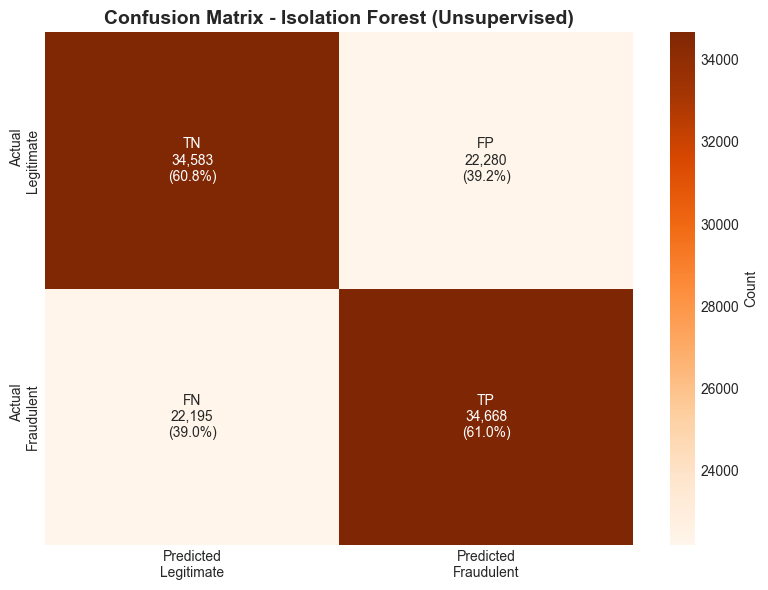


Isolation Forest - Confusion Matrix Analysis:
--------------------------------------------------
  True Negatives (TN):  34,583 - Correctly identified legitimate
  False Positives (FP): 22,280 - Legitimate flagged as fraud
  False Negatives (FN): 22,195 - Fraud not detected (MISSED!)
  True Positives (TP):  34,668 - Correctly identified fraud

  Detection Rate: 60.97% of frauds caught
  False Alarm Rate: 39.18% of legitimate flagged

--------------------------------------------------
Comparison Note:
Isolation Forest is unsupervised - it detects anomalies based on
how easily points can be 'isolated' in random trees, without using class labels.
This makes it valuable when labeled fraud data is scarce or unavailable.


In [35]:
# Confusion Matrix for Isolation Forest
print("\n" + "="*60)
print("ISOLATION FOREST - CONFUSION MATRIX")
print("="*60)

cm_iso = confusion_matrix(y_test, y_pred_iso)
tn_iso, fp_iso, fn_iso, tp_iso = cm_iso.ravel()

# Calculate percentages
cm_iso_percent = cm_iso.astype('float') / cm_iso.sum(axis=1)[:, np.newaxis] * 100

# Create figure
plt.figure(figsize=(8, 6))

# Create annotations with both count and percentage
annotations_iso = np.array([[f'TN\n{cm_iso[0,0]:,}\n({cm_iso_percent[0,0]:.1f}%)', 
                             f'FP\n{cm_iso[0,1]:,}\n({cm_iso_percent[0,1]:.1f}%)'],
                            [f'FN\n{cm_iso[1,0]:,}\n({cm_iso_percent[1,0]:.1f}%)', 
                             f'TP\n{cm_iso[1,1]:,}\n({cm_iso_percent[1,1]:.1f}%)']])

sns.heatmap(cm_iso, annot=annotations_iso, fmt='', cmap='Oranges',
            xticklabels=['Predicted\nLegitimate', 'Predicted\nFraudulent'],
            yticklabels=['Actual\nLegitimate', 'Actual\nFraudulent'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Isolation Forest (Unsupervised)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('isolation_forest_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Detailed analysis
print("\nIsolation Forest - Confusion Matrix Analysis:")
print("-"*50)
print(f"  True Negatives (TN):  {tn_iso:,} - Correctly identified legitimate")
print(f"  False Positives (FP): {fp_iso:,} - Legitimate flagged as fraud")
print(f"  False Negatives (FN): {fn_iso:,} - Fraud not detected (MISSED!)")
print(f"  True Positives (TP):  {tp_iso:,} - Correctly identified fraud")
print(f"\n  Detection Rate: {tp_iso/(tp_iso+fn_iso)*100:.2f}% of frauds caught")
print(f"  False Alarm Rate: {fp_iso/(fp_iso+tn_iso)*100:.2f}% of legitimate flagged")

print("\n" + "-"*50)
print("Comparison Note:")
print("Isolation Forest is unsupervised - it detects anomalies based on")
print("how easily points can be 'isolated' in random trees, without using class labels.")
print("This makes it valuable when labeled fraud data is scarce or unavailable.")

## 16. Best Model Selection and Final Classification Report

In [36]:
print("="*60)
print("BEST MODEL SELECTION")
print("="*60)

# Find best model based on F1 Score (balanced metric for fraud detection)
best_model_name = max(training_results, key=lambda x: training_results[x]['f1'])
best_model = trained_models[best_model_name]
best_results = training_results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"   Selection Criterion: Highest F1 Score")
print(f"   (F1 Score balances precision and recall - ideal for fraud detection)")

print("\n\nFinal Performance Metrics:")
print("-"*40)
print(f"  Accuracy:  {best_results['accuracy']*100:.2f}%")
print(f"  Precision: {best_results['precision']*100:.2f}%")
print(f"  Recall:    {best_results['recall']*100:.2f}%")
print(f"  F1 Score:  {best_results['f1']*100:.2f}%")
print(f"  ROC-AUC:   {best_results['roc_auc']*100:.2f}%")

BEST MODEL SELECTION

Best Model: Random Forest
   Selection Criterion: Highest F1 Score
   (F1 Score balances precision and recall - ideal for fraud detection)


Final Performance Metrics:
----------------------------------------
  Accuracy:  99.89%
  Precision: 99.94%
  Recall:    99.84%
  F1 Score:  99.89%
  ROC-AUC:   100.00%


In [37]:
# Detailed classification report for best model
print("\n" + "="*60)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*60)

print("\n" + classification_report(y_test, best_results['y_pred'], 
                                    target_names=['Legitimate', 'Fraudulent']))

print("\nMetric Definitions:")
print("-"*40)
print(" Precision: Of all predicted frauds, what % are actually frauds?")
print(" Recall: Of all actual frauds, what % did we catch?")
print(" F1-Score: Harmonic mean of precision and recall")
print(" Support: Number of actual occurrences of each class")


DETAILED CLASSIFICATION REPORT - Random Forest

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56863
  Fraudulent       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


Metric Definitions:
----------------------------------------
 Precision: Of all predicted frauds, what % are actually frauds?
 Recall: Of all actual frauds, what % did we catch?
 F1-Score: Harmonic mean of precision and recall
 Support: Number of actual occurrences of each class


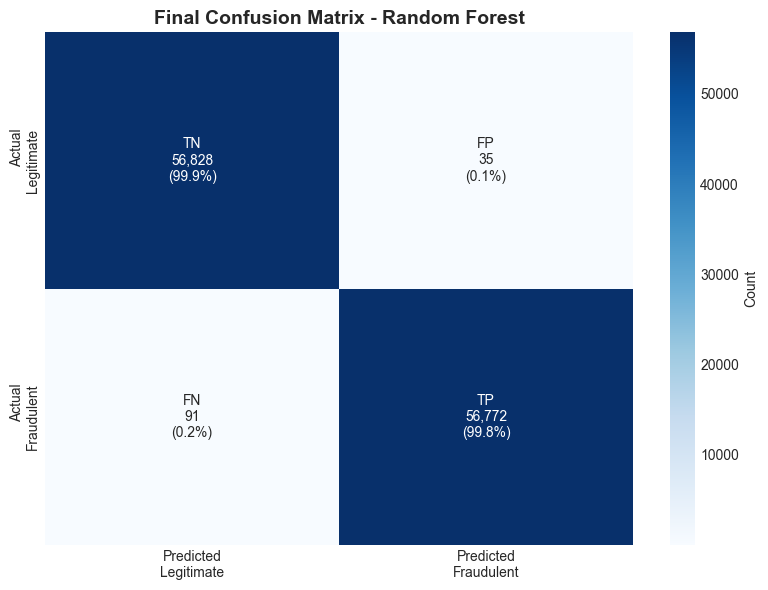


Business Impact Analysis:
----------------------------------------
 Frauds Detected (TP): 56,772 out of 56,863 (99.84%)
 Frauds Missed (FN): 91 - These would result in financial losses
 False Alarms (FP): 35 - Legitimate transactions incorrectly blocked
 Correct Approvals (TN): 56,828 - Legitimate transactions correctly approved


In [38]:
# Final confusion matrix for best model
cm = confusion_matrix(y_test, best_results['y_pred'])
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(8, 6))

# Create annotations
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
annotations = np.array([[f'TN\n{cm[0,0]:,}\n({cm_percent[0,0]:.1f}%)', 
                         f'FP\n{cm[0,1]:,}\n({cm_percent[0,1]:.1f}%)'],
                        [f'FN\n{cm[1,0]:,}\n({cm_percent[1,0]:.1f}%)', 
                         f'TP\n{cm[1,1]:,}\n({cm_percent[1,1]:.1f}%)']])

sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
            xticklabels=['Predicted\nLegitimate', 'Predicted\nFraudulent'],
            yticklabels=['Actual\nLegitimate', 'Actual\nFraudulent'],
            cbar_kws={'label': 'Count'})

plt.title(f'Final Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('final_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBusiness Impact Analysis:")
print("-"*40)
print(f" Frauds Detected (TP): {tp:,} out of {tp+fn:,} ({tp/(tp+fn)*100:.2f}%)")
print(f" Frauds Missed (FN): {fn:,} - These would result in financial losses")
print(f" False Alarms (FP): {fp:,} - Legitimate transactions incorrectly blocked")
print(f" Correct Approvals (TN): {tn:,} - Legitimate transactions correctly approved")

## 17. Summary and Conclusions

In [39]:
print("="*70)
print("                    PROJECT SUMMARY AND CONCLUSIONS")
print("="*70)

print("""
DATASET CHARACTERISTICS:
──────────────────────────────────────────────────────────────────────""")
print(f"    Total Transactions: {len(df):,}")
print(f"    Features: 29 (V1-V28 + Amount)")
print(f"    Class Distribution: {'Balanced' if 0.8 <= class_percentages[1]/class_percentages[0] <= 1.2 else 'Imbalanced'}")
print(f"    Legitimate: {class_counts[0]:,} ({class_percentages[0]:.2f}%)")
print(f"    Fraudulent: {class_counts[1]:,} ({class_percentages[1]:.2f}%)")

print("""
PREPROCESSING STEPS:
──────────────────────────────────────────────────────────────────────""")
print("   1. Removed non-predictive 'id' column")
print("   2. Scaled 'Amount' feature using RobustScaler")
print("   3. Performed 80/20 stratified train-test split")

print("""
MODELS EVALUATED:
──────────────────────────────────────────────────────────────────────""")
print("    Logistic Regression (baseline)")
print("    Decision Tree")
print("    Random Forest")
print("    XGBoost")
print("    Isolation Forest (unsupervised, for comparison)")

print("""
MODEL PERFORMANCE SUMMARY:
──────────────────────────────────────────────────────────────────────""")
print(comparison_display.to_string(index=False))

print(f"""
BEST MODEL: {best_model_name}
──────────────────────────────────────────────────────────────────────
   Selection Criterion: Highest F1 Score
   
   Final Metrics:
    Accuracy:  {best_results['accuracy']*100:.2f}%
    Precision: {best_results['precision']*100:.2f}%
    Recall:    {best_results['recall']*100:.2f}%
    F1 Score:  {best_results['f1']*100:.2f}%
    ROC-AUC:   {best_results['roc_auc']*100:.2f}%
""")

print("""
KEY INSIGHTS:
──────────────────────────────────────────────────────────────────────""")
print("   1. TO BE DONE...")
print("   2. TO BE DONE...")
print("   3. TO BE DONE...")

print("\n" + "="*70)
print("                         END OF ANALYSIS")
print("="*70)

                    PROJECT SUMMARY AND CONCLUSIONS

DATASET CHARACTERISTICS:
──────────────────────────────────────────────────────────────────────
    Total Transactions: 568,630
    Features: 29 (V1-V28 + Amount)
    Class Distribution: Balanced
    Legitimate: 284,315 (50.00%)
    Fraudulent: 284,315 (50.00%)

PREPROCESSING STEPS:
──────────────────────────────────────────────────────────────────────
   1. Removed non-predictive 'id' column
   2. Scaled 'Amount' feature using RobustScaler
   3. Performed 80/20 stratified train-test split

MODELS EVALUATED:
──────────────────────────────────────────────────────────────────────
    Logistic Regression (baseline)
    Decision Tree
    Random Forest
    XGBoost
    Isolation Forest (unsupervised, for comparison)

MODEL PERFORMANCE SUMMARY:
──────────────────────────────────────────────────────────────────────
              Model Accuracy Precision Recall F1 Score ROC-AUC
Logistic Regression   96.50%    97.70% 95.23%   96.45%  99.35%
  

## 18. Save the Best Model (Optional)

In [40]:
# Save the best model for future use
import joblib

# Save model
model_filename = f'fraud_detection_model_{best_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(best_model, model_filename)
print(f" Model saved as '{model_filename}'")

# Save scaler
joblib.dump(scaler, 'amount_scaler.joblib')
print(" Scaler saved as 'amount_scaler.joblib'")

print("\n--- How to load and use the model ---")
print("""
# Load model and scaler
model = joblib.load('fraud_detection_model_xxx.joblib')
scaler = joblib.load('amount_scaler.joblib')

# Preprocess new data
new_data['Amount'] = scaler.transform(new_data[['Amount']])

# Make predictions
predictions = model.predict(new_data)
probabilities = model.predict_proba(new_data)[:, 1]
""")

 Model saved as 'fraud_detection_model_random_forest.joblib'
 Scaler saved as 'amount_scaler.joblib'

--- How to load and use the model ---

# Load model and scaler
model = joblib.load('fraud_detection_model_xxx.joblib')
scaler = joblib.load('amount_scaler.joblib')

# Preprocess new data
new_data['Amount'] = scaler.transform(new_data[['Amount']])

# Make predictions
predictions = model.predict(new_data)
probabilities = model.predict_proba(new_data)[:, 1]

